In [1]:
from _utils import *
from scipy.stats import qmc

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

def calculate_distance_map(polys):
    # Extract the dimensions of the input array
    num_probes, num_coords, num_cells = polys.shape
    
    # Initialize an array of the same shape to hold the interpolated values
    new_maps = np.zeros((num_cells, num_probes, num_probes))
    
    # Iterate over each cell
    for c in range(num_cells):
        # Extract the data for the current cell
        curr_cells = polys[:, :, c]
        
        # Skip cells with all missing values
        if np.all(np.isnan(curr_cells)):
            continue  # This leaves a matrix of zeros in the output array
        
        # Calculate the pairwise Euclidean distance between each pair of probes
        dmap = squareform(pdist(curr_cells))
        
        # Assign the distance map to the corresponding position in the output array
        new_maps[c, :, :] = dmap
    
    # Return the array with interpolated values
    return new_maps

esc_maps_interp = calculate_distance_map(esc_polys_interp)
cnc_maps_interp = calculate_distance_map(cnc_polys_interp)
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=None)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

all_maps_pca = np.concatenate((esc_maps_pca, cnc_maps_pca), axis=0)

# Use Latin Hypercube sampling to generate 1000 samples
# This technique tries to sample data points in a way that they are evenly distributed

num_microstates = 1000
num_dimension = pca.n_components_  # pca.n_components_

sampler = qmc.LatinHypercube(d=num_dimension)
sample = sampler.random(n=num_microstates)

# We can use quantiles to get physical bounds
l_quantile = 0.01
u_quantile = 1 - l_quantile
l_bounds = np.quantile(all_maps_pca, l_quantile, axis=0)
u_bounds = np.quantile(all_maps_pca, u_quantile, axis=0)
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

# Add these sample_scaled coordinates to a dataframe
sample_df = pd.DataFrame(sample_scaled, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Inverse transform the samples
microstates_maps = pca.inverse_transform(sample_scaled)


2024-10-14 20:00:47.155520: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 20:00:47.201407: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [81]:
num_microstates = 1000
mcmc_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241014_RunWeightMCMC_Sox9_PCA_LatinCubeSampling/'

In [82]:
def load_mcmc_results(mcmc_path, num_microstates):
    # Find stan_output folder path and then load the MCMC samples
    # List all items in the current directory
    mcmc_result = {}
    for item in tqdm(os.listdir(mcmc_path)):
        # Get the full path of the item
        full_path = os.path.join(mcmc_path, item)
        
        # Check if the item is a directory
        # And if the directory contains stan_output folder
        # Check if 'stan_output' exists in the directory
        folder_path = os.path.join(full_path, 'stan_output')
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            # Load the MCMC results
            mcmc_result[item] = load_weights(folder_path, num_microstates)
            
    return mcmc_result

In [83]:
mcmc_results = load_mcmc_results(mcmc_dir, num_microstates)

  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241014192231_1.csv', '20240715_WeightOptimization-20241014192231_2.csv', '20240715_WeightOptimization-20241014192231_3.csv', '20240715_WeightOptimization-20241014192231_4.csv']
['20240715_WeightOptimization-20241014192231_1.csv', '20240715_WeightOptimization-20241014192231_2.csv', '20240715_WeightOptimization-20241014192231_3.csv', '20240715_WeightOptimization-20241014192231_4.csv']


In [84]:
mcmc_results.keys()

dict_keys(['ESC', 'CNC'])

In [85]:
esc_mcmc = mcmc_results['ESC']
cnc_mcmc = mcmc_results['CNC']

# Calculate weights of MCMC samples
esc_weights = np.exp(np.array(esc_mcmc))
cnc_weights = np.exp(np.array(cnc_mcmc))

# Concatenate 4 chains into one big matrix
esc_weights = esc_weights.reshape(-1, num_microstates)
cnc_weights = cnc_weights.reshape(-1, num_microstates)

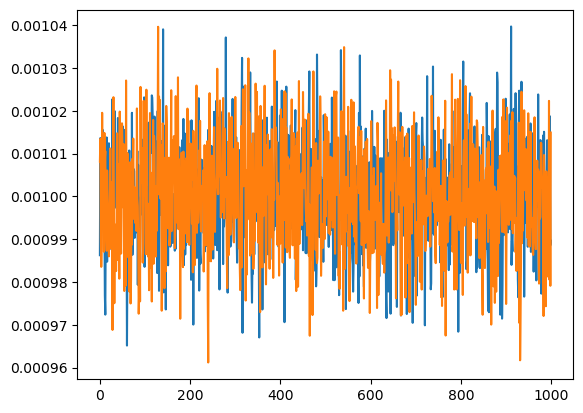

In [86]:
plt.plot(esc_weights.mean(axis=0))
plt.plot(cnc_weights.mean(axis=0))

In [87]:
def calculate_entropy(mcmc_sample):
    return np.array([scipy.stats.entropy(x) for x in mcmc_sample])

In [88]:
esc_entropy = calculate_entropy(esc_weights)
cnc_entropy = calculate_entropy(cnc_weights)

In [89]:
# Add these entropy values into a dataframe
esc_entropy_df = pd.DataFrame(esc_entropy, columns=['Entropy'])
cnc_entropy_df = pd.DataFrame(cnc_entropy, columns=['Entropy'])
esc_entropy_df['label'] = 'ESC'
cnc_entropy_df['label'] = 'CNC'
all_entropy_df = pd.concat([esc_entropy_df, cnc_entropy_df], axis=0)

<Axes: xlabel='label', ylabel='Entropy'>

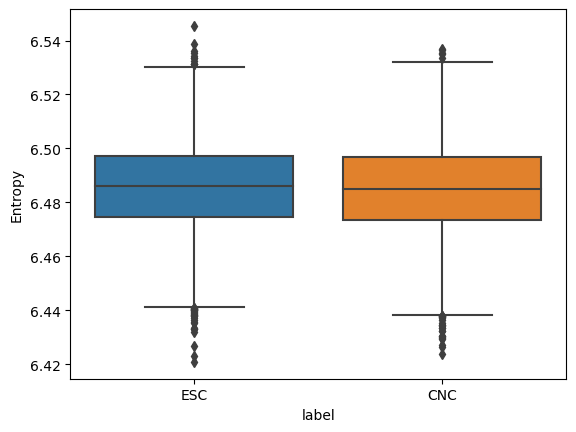

In [90]:
# Joint entropy is identical 
sns.boxplot(x='label', y='Entropy', data=all_entropy_df)

In [91]:
np.log(1000)

6.907755278982137

In [92]:
sampled_microstates_pca_coords_path = os.path.join(mcmc_dir, 'sampled_microstates.csv')
# load the sampled microstates
sampled_microstates = pd.read_csv(sampled_microstates_pca_coords_path)
# Add weights to the sampled microstates
sampled_microstates['ESC'] = esc_weights.mean(axis=0)
sampled_microstates['CNC'] = cnc_weights.mean(axis=0)

In [93]:
sampled_microstates.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC2975,PC2976,PC2977,PC2978,PC2979,PC2980,PC2981,PC2982,ESC,CNC
0,-2795.002928,-3447.469661,6585.734229,7806.865430,-311.007107,-7475.798825,-5791.930067,4697.717843,-5442.171536,913.635291,...,0.036707,0.103515,-0.275556,0.097073,1.590113e-11,6.486412e-13,5.030360e-13,-6.991343e-14,0.000986,0.001008
1,-10357.404732,2337.169407,-8751.203168,8249.769687,4320.155906,-4882.650797,5843.914027,-3150.856743,4001.128559,3118.448083,...,0.075551,-0.128603,-0.186471,0.034237,1.639076e-11,6.584347e-13,-6.934044e-14,6.507943e-13,0.001014,0.001013
2,-11032.235131,-2288.795634,-4948.886026,352.640510,-7669.916734,5968.801594,5757.203720,5176.704826,-3461.424794,-2963.564441,...,-0.176628,-0.022382,0.217669,-0.000296,1.615533e-11,-5.305592e-13,5.698787e-14,5.552411e-13,0.000989,0.000990
3,546.505417,-11000.762052,2894.091322,-2399.359482,-4877.881450,4982.007723,-311.798093,-1815.202417,-3393.382886,2355.547034,...,-0.152604,-0.040127,0.071999,0.051062,1.589420e-11,2.885704e-13,2.537532e-13,-5.581022e-14,0.000994,0.000984
4,-12646.302664,-383.886776,1437.484020,-7100.276439,6090.066940,2992.586206,-1321.078797,-1335.201553,2223.681192,1130.747350,...,0.055075,-0.195989,-0.043366,0.014905,1.590771e-11,-5.863963e-13,-2.367269e-13,-5.434191e-13,0.001000,0.000988


In [94]:
# Sort microstates based on PC1
sampled_microstates = sampled_microstates.sort_values(by='PC1')

In [95]:
sampled_microstates[['PC1', 'ESC', 'CNC']]

,PC1,ESC,CNC
163,-24813.670059,0.001001,0.001007
538,-24790.437468,0.001004,0.001011
724,-24732.871169,0.000996,0.001000
207,-24702.579925,0.000970,0.001015
881,-24670.239200,0.001027,0.000983
...,...,...,...
565,16886.713991,0.000989,0.000999
917,16908.264174,0.001020,0.000994
122,16985.969727,0.000999,0.000996
220,17020.010842,0.000978,0.001011


In [96]:
# Find the rolling mean of the weights
sampled_microstates['ESC_rolling'] = sampled_microstates['ESC'].rolling(window=100).mean()
sampled_microstates['CNC_rolling'] = sampled_microstates['CNC'].rolling(window=100).mean()

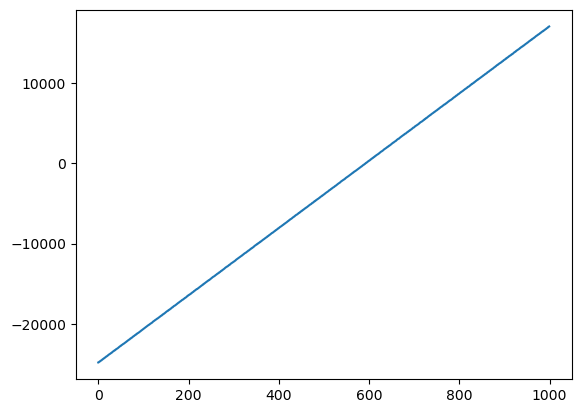

In [97]:
plt.plot(np.arange(1000), sampled_microstates['PC1'])

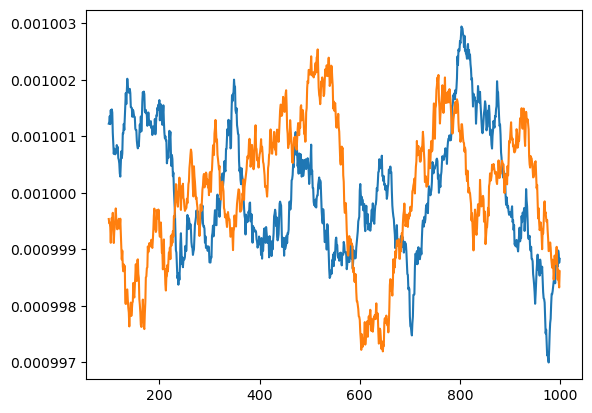

In [98]:
plt.plot(np.arange(1000), sampled_microstates['ESC_rolling'])
plt.plot(np.arange(1000), sampled_microstates['CNC_rolling'])